# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports
import pickle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import transform
import cv2
import numpy as np

# Load pickled data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_all, y_train_all = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train_all)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_all[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train_all)-np.min(y_train_all)+1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

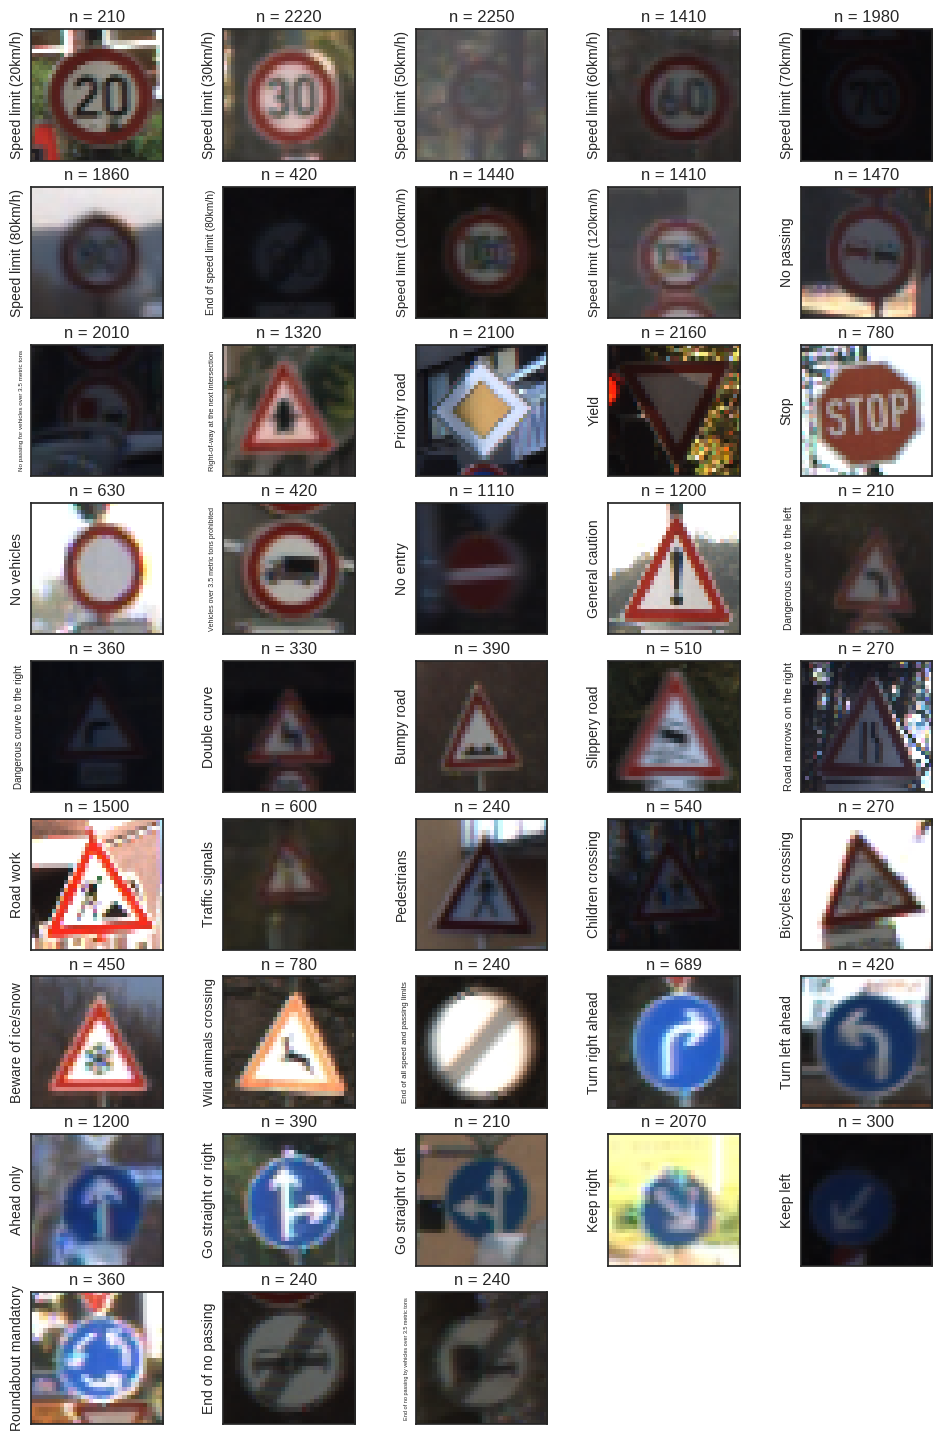

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 18.0)
plt.rcParams['image.interpolation'] = 'nearest'

# Calculate label distribution
label_count = np.bincount(y_train_all)
df = pd.read_csv('signnames.csv')

# Plot one image for each label
for c in range(0, n_classes):
    idx_this_class = np.where(y_train_all==c)[0]
    with sns.axes_style("white"):
        plt.subplot(9,5,c+1)
    plt.imshow(X_train_all[np.random.choice(idx_this_class)])
    plt.tick_params(
        which='both', bottom='off', left='off', top='off', right='off', labelbottom='off', labelleft='off')
    plt.ylabel(df.loc[c].SignName, fontsize=200/(np.max([20,len(df.loc[c].SignName)])))
    plt.title('n = {}'.format(label_count[c]))   
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
def preprocess_data(X):
    # Normalize to range 0-1
    X = np.divide(X, 255)
    
    # Convert to gray image / weighted
    X = 0.114 * X[...,0] + 0.587 * X[...,1] + 0.299 * X[...,2] # BGR->Gray
    # +0.04
    
    # Subtract Mean Image
    # X -= np.mean(X, axis=0).astype(X.dtype)
    # -0.05 
    
    # Convert to gray image / average
    # X = np.mean(X, axis=3, keepdims=1)
    # -0.02
    
    return X

In [5]:
X_train_all = preprocess_data(X_train_all)
X_test = preprocess_data(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I basically just used two preprocessing steps 
* Rescale input to (0,1)
* Convert color images to gray scale

After changing the preprocessing I did a rerun and wrote down the validation accuracy to observe the effect of the change. As can be seen in the code cell above, all other preprocessing steps made validation accuracy worse (value is indicated in #comment)

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [7]:
def balance_class(X, y, n_add, set_ratio=20):
    """Balances the classes by generating additional pictures for given class"""
    if n_add < 10: return X, y
    set_size = n_add//set_ratio
    augmented_X, augmented_y = X, y
    for br in range(0, set_ratio):
        image_shape = X[0].shape
        transformation_parameter = get_transformation_parameter(image_shape)
        # Set a random subset of points in another perspective
        this_set = np.random.choice(X.shape[0],set_size)
        augmented_X_in = np.array([cv2.warpPerspective(X[i],transformation_parameter,image_shape) for i in this_set])
        augmented_X = np.vstack((augmented_X, augmented_X_in))
        augmented_y = np.hstack((augmented_y,y[this_set]))
    return augmented_X, augmented_y

def get_transformation_parameter(image_shape):
    """Returns random parameters for a perspective transform"""
    #With Perspective transform left
    edges = np.float32([[0,0],[image_shape[0],0],[0,image_shape[1]],[image_shape[0],image_shape[1]]])
    warp_strength = np.random.randint(4, 5)
    # Generate left and right perspectives
    perspective_left = np.float32([[0,0],[image_shape[0],warp_strength],[0,image_shape[1]],[image_shape[0],image_shape[1]-warp_strength]])
    perspective_right = np.float32([[0,warp_strength],[image_shape[0],0],[0,image_shape[1]-warp_strength],[image_shape[0],image_shape[1]]])
    # Generate Perspective transform
    perspective_left = cv2.getPerspectiveTransform(edges, perspective_left)
    perspective_right = cv2.getPerspectiveTransform(edges, perspective_right)
    
    return perspective_left if np.random.uniform(0,1) > 0.5 else perspective_right

def balance_classes(X, y, n_classes):
    """Balances the class distributions"""
    X_balanced = []
    y_balanced = []
    class_distributions = np.bincount(y)
    class_size_max = np.max(class_distributions)
    for c in range(0, n_classes):
        this_class_X = X[y==c]
        this_class_y = y[y==c]
        this_class_to_add = class_size_max-len(this_class_y)
        augmented_X, augmented_y = balance_class(this_class_X, this_class_y, this_class_to_add)
        X_balanced.append(augmented_X)
        y_balanced.append(augmented_y)
    return np.vstack(X_balanced), np.hstack(y_balanced)

In [8]:
# Balance Classes
X_train_all_balanced, y_train_all_balanced = balance_classes(X_train_all, y_train_all, n_classes)
#+0.2

In [9]:
# Create Validation Set
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_all_balanced, y_train_all_balanced, test_size=0.2)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used the test data directly from the files while I split the training data into a validation (20%) and a training set (80%). 

First I balanced the class distributions with the help of augmented images. The augmented image was created with a projection to transform the perspective of the image. This transformation is useful as not all traffic signs are captured frontally, so the additional images should help improving the overall generalization of the network. 

In [10]:
# Define all network parameters
mu = 0
sigma = 0.1

# and training parameters
epochs = 20
batch_size = 128

In [11]:
# Define Layer Depths
layer_depth = {
    'layer_1': 12,
    'layer_2': 32,
    'fully_connected_1': 512,
    'fully_connected_2': 256,
    'out': n_classes,
}
#+0.25

#layer_depth = {
#    'layer_1': 12,
#    'layer_2': 32,
#    'fully_connected_1': 120,
#    'fully_connected_2': 84,
#    'out': n_classes,
#}
#+0.05

#layer_depth = {
#    'layer_1': 12,
#    'layer_2': 32,
#    'fully_connected_1': 240,
#    'fully_connected_2': 168,
#    'out': n_classes,
#}
#+0.1

#layer_depth = {
#    'layer_1': 24,
#    'layer_2': 64,
#    'fully_connected_1': 480,
#    'fully_connected_2': 340,
#    'out': n_classes,
#}
#-0.05

In [12]:
def he_et_al_initialization(input_shape):
    return tf.Variable(tf.random_normal(input_shape)
                           * tf.sqrt(tf.constant(2.0/np.sum(input_shape), dtype=tf.float32)))

In [13]:
weights = {
    'layer_1': he_et_al_initialization((5, 5, 1, layer_depth['layer_1'])),
    'layer_2': he_et_al_initialization((5, 5, layer_depth['layer_1'], layer_depth['layer_2'])),
    'fully_connected_1': he_et_al_initialization((5*5*layer_depth['layer_2'], layer_depth['fully_connected_1'])),
    'fully_connected_2': he_et_al_initialization((layer_depth['fully_connected_1'], layer_depth['fully_connected_2'])),
    'out': he_et_al_initialization((layer_depth['fully_connected_2'], layer_depth['out']))
}
#+0.3 over the first epochs than +-0

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'out': tf.Variable(tf.zeros(layer_depth['out']))
}


#weights = {
#    'layer_1': tf.Variable(tf.truncated_normal(
#        [5, 5, 1, layer_depth['layer_1']], mean=mu, stddev=sigma)),
#    'layer_2': tf.Variable(tf.truncated_normal(
#        [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean=mu, stddev=sigma)),
#    'fully_connected_1': tf.Variable(tf.truncated_normal(
#        [5*5*layer_depth['layer_2'], layer_depth['fully_connected_1']])),
#    'fully_connected_2': tf.Variable(tf.truncated_normal(
#        [layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean=mu, stddev=sigma)),
#    'out': tf.Variable(tf.truncated_normal(
#        [layer_depth['fully_connected_2'], layer_depth['out']], mean=mu, stddev=sigma))
#}


In [14]:
# Define helper functions
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding = 'VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1],
                         strides=[1, k, k, 1],
                         padding='VALID')

In [15]:
# Define Architecture
keep_prob = tf.placeholder(tf.float32)
def LeNetTransformed(x):
    # Input = 32x32x1. Output = 28x28x12.
    x = tf.expand_dims(x, -1)
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = tf.nn.relu(conv1)
    # Input = 28x28x12. Output = 14x14x32.
    conv1 = maxpool2d(conv1)
    
    # Output = 10x10x32.
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = tf.nn.relu(conv2)
    # Input = 10x10x32. Output = 5x5x32.
    conv2 = maxpool2d(conv2)
    
    # Input = 5x5x32. Output = 320.
    fc0 = flatten(conv2)
    
    # Input = 320. Output = 512.
    fc1 = tf.add(tf.matmul(fc0, weights['fully_connected_1']), biases['fully_connected_1'])
    fc1 = tf.nn.relu(fc1)
    
    # Add Dropout 
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    # +0.02
    
    # Input = 512. Output = 256.
    fc2 = tf.add(tf.matmul(fc1, weights['fully_connected_2']), biases['fully_connected_2'])   
    fc2 = tf.nn.relu(fc2)
    
    # Add Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)
    # +0.01
    
    # Input = 256. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The model basis is from the LeNet paper while I used other parameters for the filters and number of neurons. 
* Layer 1 : 5x5 Filter with depth 12
* Layer 2 : 5x5 Filter with depth 32
* Fully Connected Layer : n = 512
* Dropout Layer : Dropout Value = 0.8
* Fully Connected Layer : n = 256
* Dropout Layer : Dropout Value = 0.8

In [16]:
# Add Saver object to save model
saver = tf.train.Saver()

# Add placeholder for input and labels
x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [17]:
learning_rate = 0.001
# Setup training
# 1.) Get Logits from Architecture
logits = LeNetTransformed(x)
# 2.) Calculate Cross Entropy and sum over all training samples
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
# 3.) Minimize loss with given learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Without regulariztaion
training_operation = optimizer.minimize(loss_operation)

# With regularization
#reg = 0.001
#loss_operation = loss_operation + (reg*tf.nn.l2_loss(weights['layer_1']) +
#    reg*tf.nn.l2_loss(weights['layer_2']) +
#    reg*tf.nn.l2_loss(weights['fully_connected_1']) +
#    reg*tf.nn.l2_loss(weights['fully_connected_2']) + 
#    reg*tf.nn.l2_loss(weights['out']))
#training_operation = optimizer.minimize(loss_operation)

In [18]:
# Setup Evaluation
# 1.) Get Accuracy by comparing one hot encode label with output
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 2.) Add evaluation method 
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
# Run Training and save model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print('Number of training samples: {}'.format(num_examples))
    print('Training...')
    print()
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.8})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, 'traffic-sign_model')
    print('Model Saved')

Number of training samples: 77207
Training...

EPOCH 1 ...
Validation Accuracy = 0.942

EPOCH 2 ...
Validation Accuracy = 0.977

EPOCH 3 ...
Validation Accuracy = 0.982

EPOCH 4 ...
Validation Accuracy = 0.989

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.991

EPOCH 7 ...
Validation Accuracy = 0.989

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.995

EPOCH 10 ...
Validation Accuracy = 0.994

EPOCH 11 ...
Validation Accuracy = 0.995

EPOCH 12 ...
Validation Accuracy = 0.994

EPOCH 13 ...
Validation Accuracy = 0.995

EPOCH 14 ...
Validation Accuracy = 0.995

EPOCH 15 ...
Validation Accuracy = 0.997

EPOCH 16 ...
Validation Accuracy = 0.995

EPOCH 17 ...
Validation Accuracy = 0.997

EPOCH 18 ...
Validation Accuracy = 0.996

EPOCH 19 ...
Validation Accuracy = 0.997

EPOCH 20 ...
Validation Accuracy = 0.996

Model Saved


In [20]:
# Test Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I initialized my weights with a normal distribution with zero mean and 0.1 standard deviation (which i later changed to the better He et al. initialization). I used the cross entropy to calculate the accuracies and the adam optimizer to improve weights during training (batch size = 128, epochs=20).


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started out with the LeNet model as this model gave good initial results. I modified the model by changing the depth of the filters and the number of neurons used in the fully connected Layers. 

Surprisingly after converting the images to grayscale I achieved higher accuracies, maybe because colors are not good for distinguishing traffic sings, as for example a lot of them have red somewhere in the sign but with different meanings. 

Moreover I tried different ways of balancing the classes with augmented images (rotation, shear, translation, perspective) and found the perspective transform to give the best accuracy. 

In the end I also tried a different initialization approach for the weights as this was suggested in the CS231n course. I saw slight improvements when using this initialization instead of the original one. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
images_resized = []
images = []
for image_path in glob.glob('./extra_images/*.jpg'):
    image = plt.imread(image_path)
    image_resized = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    images_resized.append(image_resized)
    image_preprocessed = preprocess_data(image_resized)
    images.append(image_preprocessed[np.newaxis,...])
images = np.vstack(images)

In [22]:
# Test Model on new images
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    new_saver = tf.train.import_meta_graph('traffic-sign_model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    out = sess.run(tf.argmax(logits, 1), feed_dict={x: images, keep_prob: 1})

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I noticed that he has problems with signs he never saw before as the fourth picture where the bicycle lane and the pedestrian lane are shared. Moreover images which are not centered in the middle of the image are harder to classify as well as images where not only one but two or more traffic signs are shown. 

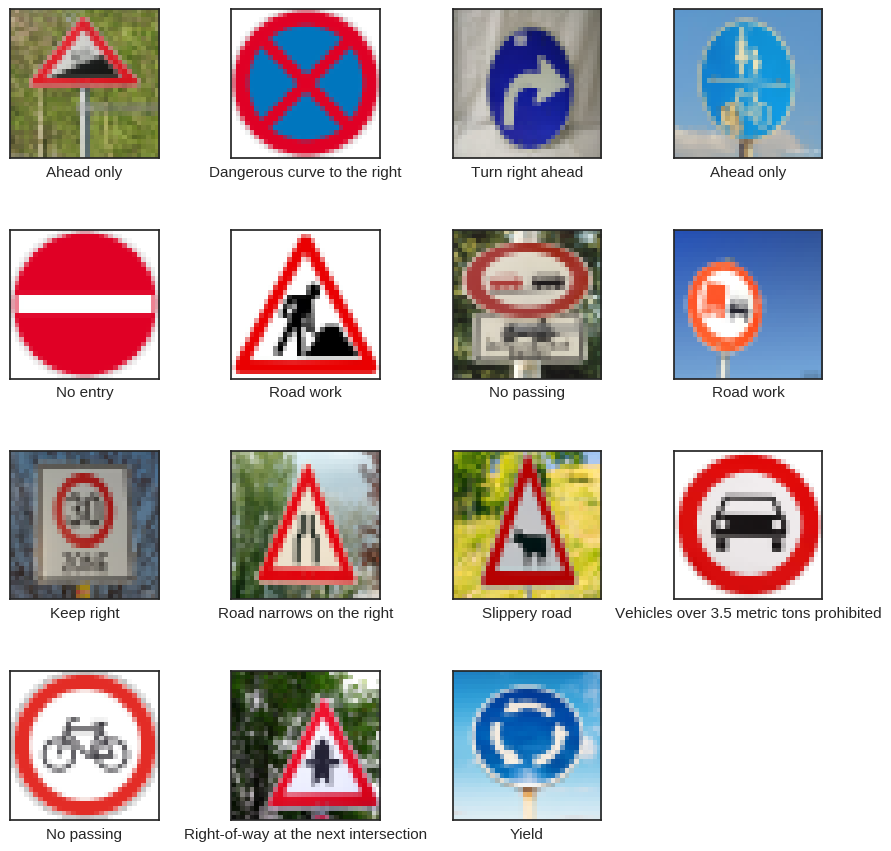

In [23]:
# Plot Images with prediction
plt.figure(figsize=(9,9))
for i in range(0,images.shape[0]):
    with sns.axes_style("white"):
        plt.subplot(4, 4, i+1)
    plt.imshow(np.squeeze(images_resized[i]), cmap='gray')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.xlabel(df.loc[out[i]].SignName)
    plt.tight_layout()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The accuracy for this dataset of images is 7/15 (around 46%) which is far worse than the above stated test accuracy. 

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [25]:
# Test Model
k = 5
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    new_saver = tf.train.import_meta_graph('traffic-sign_model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    out_prob = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=k), feed_dict={x: images, keep_prob: 1})

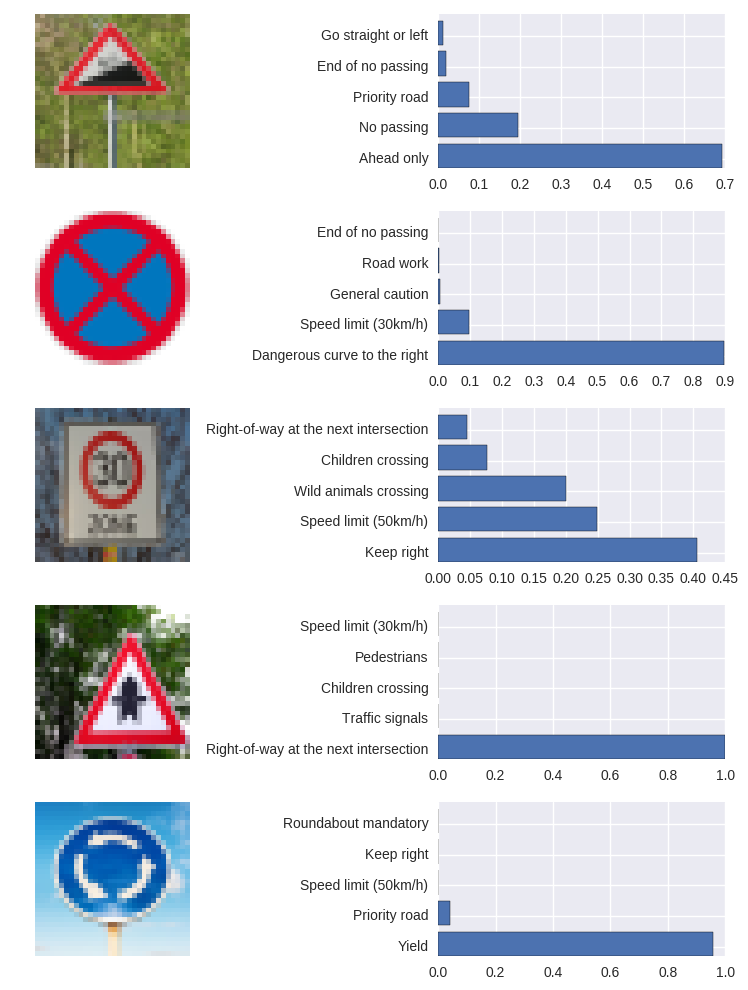

In [26]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
#image_indices = (2,9,3,10,12)
image_indices = (0,1,8,13,14)
#image_indices = np.arange(0, len(images_resized))
for i, im in enumerate(image_indices):
    with sns.axes_style("white"):
        plt.subplot(len(image_indices), 2, (2*i)+1)
    plt.imshow(np.squeeze(images_resized[im]), cmap='gray')
    plt.axis('off')
    #plt.xlabel(df.loc[out[i]].SignName)
    plt.subplot(len(image_indices) ,2, (2*i)+2)
    plt.barh(np.arange(k), out_prob.values[im])
    plt.yticks(np.arange(k)+0.3, df.loc[out_prob.indices[im]].SignName)
    plt.tight_layout()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

1. Shows clear uncertainty as this category was never seen by the model
2. Also never before seen category but it is a bit weird that the highest prediction is general caution as these signs have completly different shapes
3. Here the correct class is in the top 5. The classification was probably complicated by the fact that this sign has more information than just the speed limit on it
4. Correctly classified
5. Correct class is in top 5 but it is a bit weird that he sees a speed limit sign in there. Probably the color information would yield better results for this!

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.